This notebook is to get a working fit over the raw energy data using three CB funcs (zfit natively defined funcs) and logistic background (defined manually) 

In [1]:
import tensorflow as tf
import zfit
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import math

/opt/anaconda3/envs/m2_req/lib/python3.10/site-packages/zfit/__init__.py:59: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


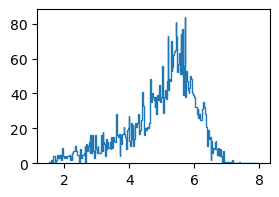

In [2]:
data = zfit.Data.from_root("mu2e_caloSimu_crySpec867_TTREE.root", "specTree", ["spec", "ratio", "ntrig", "stim", "time", "tErg"]) #importing data from root file
energy_unbinned = data["spec"] #crystal spec is the raw energy values
bin_count = 260 #trivially set depending on what we want the y axis to represent (x evts/kev)
plt.figure(figsize=(3,2))
energy_binned, bin_location, patches = plt.hist(energy_unbinned,bins=bin_count,histtype='step',range=(1.5,8)) #binning energy values and creating an x array of bin location
bin_centers =  (bin_location[1:] + bin_location[:-1])/2 #creating x array of bin location

#### Parameters for 3 peaks

In [3]:
cryspec = zfit.Space(['x'], limits=(1.5,8)) #obs range
ergElec = 0.511
fcbalpha = zfit.Parameter("fcbalpha", 2.5, 0.05, 20.0);
fcbndeg = zfit.Parameter ("fcbndeg", 10, 0.25, 80.);
#A = zfit.Parameter ("A constant", 0.0169, 0.0149, 0.0189);
#B = zfit.Parameter ("B constant", 0.01, 0.005, 0.04);
#A = zfit.Parameter ("A constant", 0.02);
#B = zfit.Parameter ("B constant", 0.02);

#full Peak
fullPeak = zfit.Parameter( "full peak", 6, 5.6, 6.2); 
fullRes = np.sqrt(pow(0.0169/pow((fullPeak/1000),0.25),2)) + (0.01)**2 + (0.15/fullPeak)**2 #fractional resolution
fullWidth = zfit.Parameter( "width of the full peak",0.3); 
frFull = zfit.Parameter("Fraction of full peak", 1000);

#params for fst peak
fstEsPeak = fullPeak - ergElec 
fstRes = np.sqrt(pow(0.0169/pow((fstEsPeak/1000),0.25),2)) + (0.01)**2 + (0.15/fstEsPeak)**2 #fractional resolution
fstWidth = zfit.Parameter("width of first escape peak",0.3); 
frFrst = zfit.Parameter("Fraction of first escape peak", 400);

#params for scnd peak
scdEsPeak = fullPeak - 2*ergElec
scdRes = np.sqrt(pow(0.0169/pow((scdEsPeak/1000),0.25),2)) + (0.01)**2 + (0.15/scdEsPeak)**2 #fractional resolution
scdWidth = zfit.Parameter("width of second escape peak", 0.3);
frScd = zfit.Parameter("Fraction of second escape peak", 500);

#logistic background parameters
comCnst = zfit.Parameter("comCnst", 4, 1, 20)
combeta = zfit.Parameter("combeta", 1, 0.01, 30)
frBG = zfit.Parameter("Fraction of logistic background",len(energy_unbinned)-frFull-frFrst-frScd)
#frBG = zfit.Parameter("Fraction of logistic background",0.3,0.1,1.0)
print(fullRes)

tf.Tensor(0.06144739492176123, shape=(), dtype=float64)


#### Logistic background PDF

In [4]:
class bckgrndPDF(zfit.pdf.ZPDF):
    _N_OBS = 1
    _PARAMS = ['comCnst3', 'combeta3']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x = zfit.z.unstack_x(x)
        comCnst = self.params['comCnst3']
        combeta = self.params['combeta3']
        return 1.0/(1.0+tf.math.exp((x-comCnst)/combeta))

#### Range, Scale and Limits

In [5]:
lower, upper = cryspec.limits
x_range= cryspec.area() 
scale = (len(energy_unbinned)/bin_count)*x_range #the pdfs are normalised to =1 so must apply scaling factor
bin_centers =  (bin_location[1:] + bin_location[:-1])/2

#### PDF Definition

In [6]:
fullErg = zfit.pdf.CrystalBall(obs=cryspec, mu=fullPeak, sigma=fullWidth, alpha=fcbalpha, n=fcbndeg, extended=frFull)
firstErg = zfit.pdf.CrystalBall(obs=cryspec,mu=fstEsPeak,sigma=fstWidth,alpha=fcbalpha, n=fcbndeg, extended=frFrst)
secdErg = zfit.pdf.CrystalBall(obs=cryspec, mu=scdEsPeak, sigma=scdWidth, alpha=fcbalpha, n=fcbndeg, extended=frScd)
background = bckgrndPDF(obs=cryspec, comCnst3=comCnst,combeta3=combeta, extended = frBG)
comb_fit = zfit.pdf.SumPDF([fullErg,firstErg,secdErg,background],obs=cryspec,extended = True)

#### Running PDF

In [7]:
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_first = firstErg.pdf(bin_centers,norm_range=cryspec)
y_plot_secd = secdErg.pdf(bin_centers,norm_range=cryspec)
y_plot_comb = comb_fit.pdf(bin_centers,norm_range=cryspec)
y_plot_logistic = background.pdf(bin_centers,norm_range=cryspec)

Total Sum of all 4 fractions:  tf.Tensor(4681.0, shape=(), dtype=float64)


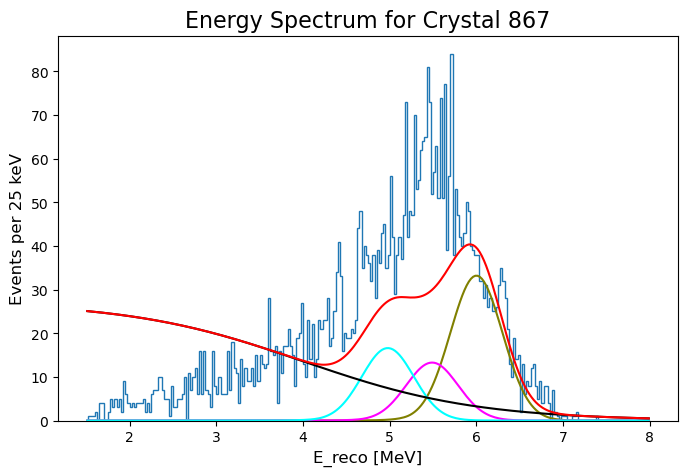

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hist(energy_unbinned,bins=bin_count,histtype='step',range=(1.5,8))

plt.plot(bin_centers, y_plot_full*scale*frFull/len(energy_unbinned), color="olive", label='Full Peak CB')
plt.plot(bin_centers, y_plot_first*scale*frFrst/len(energy_unbinned), color="magenta",label='1st Esc Peak')
plt.plot(bin_centers, y_plot_secd*scale*frScd/len(energy_unbinned), color="cyan",label='2nd Esc Peak')
#logistic background
plt.plot(bin_centers, y_plot_logistic*scale*frBG/len(energy_unbinned), color="black", label='Full Peak CB')

#Combined Fit
plt.plot(bin_centers, y_plot_comb*scale, color="red",label='Combined Fit')

plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)
print("Total Sum of all 4 fractions: " ,frFull+frFrst+frScd+frBG)

In [24]:
nll_fit = zfit.loss.ExtendedUnbinnedNLL(model=comb_fit, data=energy_unbinned)

minimizer = zfit.minimize.Minuit()

result = minimizer.minimize(nll_fit, params=[fcbalpha,fcbndeg,
                                                  fullPeak,frFull,
                                                  frFrst,frScd,
                                                  comCnst,combeta])
param_hesse=result.hesse()
print(result)
print(frBG)
print(fullWidth)
print(fstWidth)
print(scdWidth)
print("Actual value of Frst Peak:",fstEsPeak)
print("Actual value of Scnd Peak:",scdEsPeak)
print("Expected value of Frst Peak:",fullPeak-0.511)
print("Expected value of scnd Peak:",fullPeak-2*0.511)
print(fullRes)
print("Total # of evts:",len(energy_unbinned))
print("Total Sum of all 4 fractions: ", frFull+frFrst+frScd+frBG)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_3, Composed_autoparam_4, Composed_autoparam_5, Composed_autoparam_6]] data=[<zfit.Data: Data obs=('x',) shape=(4681, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  False  │    True     │       True       │ 4.5e-05 │        -28215.61 |  10008.16 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name                              value  (rounded)        hesse    at limit
------------------------------  ------------------  -----------  ----------
fcbalpha                                  0.735516  +/-   0.058       False
fcbndeg                                        

#### Re-running PDF's so that the new minimized values are applied

In [10]:
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_first = firstErg.pdf(bin_centers,norm_range=cryspec)
y_plot_secd = secdErg.pdf(bin_centers,norm_range=cryspec)
y_plot_comb = comb_fit.pdf(bin_centers,norm_range=cryspec)
y_plot_logistic = background.pdf(bin_centers,norm_range=cryspec)
norm=1/(frFull+frFrst+frScd)

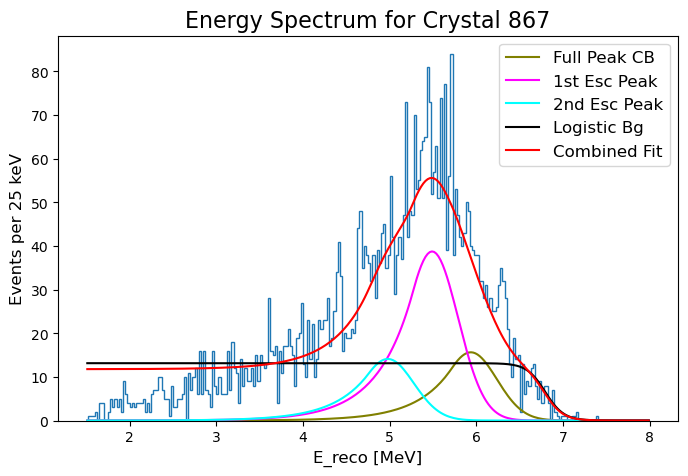

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
energy_binned, bin_location, patches = ax.hist(energy_unbinned,
                           bins=(bin_count),histtype='step',
                           range=(1.5,8))

plt.plot(bin_centers, y_plot_full*scale*frFull/len(energy_unbinned), color="olive", label='Full Peak CB')
plt.plot(bin_centers, y_plot_first*scale*frFrst/len(energy_unbinned), color="magenta",label='1st Esc Peak')
plt.plot(bin_centers, y_plot_secd*scale*frScd/len(energy_unbinned), color="cyan",label='2nd Esc Peak')
#logistic background
plt.plot(bin_centers, y_plot_logistic*scale*frBG/len(energy_unbinned), color="black", label='Logistic Bg')

#Combined Fit
plt.plot(bin_centers, y_plot_comb*scale, color="red",label='Combined Fit')

plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)
leg = plt.legend(fontsize=12);

In [12]:
integral_combined = comb_fit.integrate(limits=(lower,upper))
integral_combined

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.])>